远程使用 Jupyter Notebook （iPython Notebook）
=============================================

原文见 [远程使用 Jupyter Notebook （iPython Notebook）](http://tangzx.qiniudn.com/post-0109-remote-jupyter.html)。

ipython notebook 是一个便于使用的浏览器内 python 交互界面。现在改名为 Jupyter。

在命令行下输入 `ipython notebook`{.bash} 就可以打开当前文件夹，下面的 `*.ipynb`
就是一个 ipython 笔记本。

但不幸的是，你不能在服务器上打开 ipython notebook，然后回到自己的笔记本上输入
ip 端口进行登陆。如果看过官方的文档，你发现其实可以把服务公开给其他电脑使用，不过
很麻烦。

这里有一个更简单的解决方案：

-   在服务器上，`ipython notebook --no-browser --port=8889` 在 8889 端口打开 notebook 服务
-   用 ssh 连接到服务器，并把服务器的端口接通到一个公共的端口：`ssh -N -f -L localhost:8888:localhost:8889 tzx@192.168.1.106`
    这里的 `tzx@192.168.1.106` 是远程服务器和用户名
-   然后就可以在本地打开 `localhost:8888` 连接到 notebook 里了

refs and see also

  - [Coderwall | Remote Access to IPython Notebooks via SSH](https://coderwall.com/p/ohk6cg/remote-access-to-ipython-notebooks-via-ssh)
  - [SSH/OpenSSH/PortForwarding - Community Help Wiki](https://help.ubuntu.com/community/SSH/OpenSSH/PortForwarding)
  
# 说明

-   在运行前可以先看看之前的运行结果；
-   然后清除所有的 cell output，自己运行一遍


# Instant Recognition with Caffe

In this example we'll classify an image with the bundled CaffeNet model based on the network architecture of Krizhevsky et al. for ImageNet. We'll compare CPU and GPU operation then reach into the model to inspect features and the output.

(These feature visualizations follow the DeCAF visualizations originally by Yangqing Jia.)

First, import required modules, set plotting parameters, and run `./scripts/download_model_binary.py models/bvlc_reference_caffenet` to get the pretrained CaffeNet model if it hasn't already been fetched.

In [2]:
# 用迅雷下载更加快：http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel
# 下载后用 scp 传到服务器：scp bvlc_reference_caffenet.caffemodel tzx@192.168.1.106:~/datasets/
# 在 control-enter 运行这个 cell 前，把 model 文件拷贝到相应目录，这样就无需下载了
# cp $DATASETS_DIR/bvlc_reference_caffenet.caffemodel ~/dev/caffe-rc3/models/bvlc_reference_caffenet/

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os
if not os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet
else:
    print "已经有文件，无需下载。"

print "done."

已经有文件，无需下载。
done.


Set Caffe to CPU mode, load the net in the test phase for inference, and configure input preprocessing.

In [4]:
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt',
                caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
print "done"

done


Let's start with a simple classification. We'll set a batch of 50 to demonstrate batch processing, even though we'll only be classifying one image. (Note that the batch size can also be changed on-the-fly.)

In [5]:
# set net to batch size of 50
net.blobs['data'].reshape(50,3,227,227)
print "done"

print net

net?
print net.blobs['data']
print net.blobs['data'].shape

done


因为是 ipython，所以可以查看帮助，比如 `net?`，想看更详细的帮助，用 `net??`。
帮助窗口会出现在下方。

Feed in the image (with some preprocessing) and classify with a forward pass.

In [7]:
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/cat.jpg'))
out = net.forward()
print("Predicted class is #{}.".format(out['prob'][0].argmax()))

print transformer
print "done"

Predicted class is #281.
<caffe.io.Transformer instance at 0x7fdac2fc0d88>
done


In [8]:
print net.forward

<bound method Net._Net_forward of <caffe._caffe.Net object at 0x7fdac3047788>>


What did the input look like?

50

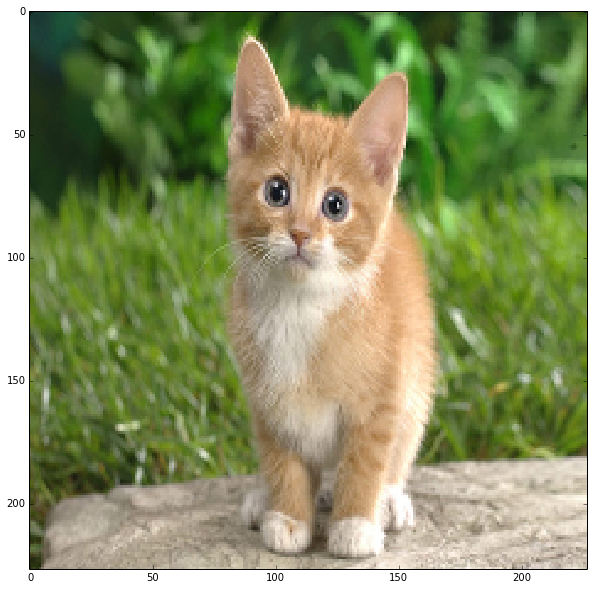

In [9]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[39]))
len(net.blobs['data'].data)

比起 ssh 连接远程服务器，好处是有图形界面。可以把结果图片（当然这里还不是结果）显示出来。
ipython notebook (jupyter) 牛逼就在这里。

Adorable, but was our classification correct?

In [10]:
# load labels
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print labels[top_k]
print "done"

['n02123045 tabby, tabby cat' 'n02123159 tiger cat'
 'n02124075 Egyptian cat' 'n02119022 red fox, Vulpes vulpes'
 'n02127052 lynx, catamount']
done


Indeed! But how long did it take?

In [11]:
# CPU mode
net.forward()  # call once for allocation
%timeit net.forward()
# timeit 就是 ipython 提供的 magic 函数之一

1 loop, best of 3: 4.7 s per loop


That's a while, even for a batch size of 50 images. Let's switch to GPU mode.

In [12]:
# GPU mode
caffe.set_device(0)
caffe.set_mode_gpu()
net.forward()  # call once for allocation
%timeit net.forward()

10 loops, best of 3: 56.1 ms per loop


可以看到性能提升是明显的：

-   CPU: 1 loop, best of 3: 4.7 s per loop
-   GPU: 10 loops, best of 3: 56.1 ms per loop
        
有一百倍的性能提升。

Much better. Now let's look at the net in more detail.

First, the layer features and their shapes (1 is the batch size, corresponding to the single input image in this example).

In [13]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (50, 3, 227, 227)),
 ('conv1', (50, 96, 55, 55)),
 ('pool1', (50, 96, 27, 27)),
 ('norm1', (50, 96, 27, 27)),
 ('conv2', (50, 256, 27, 27)),
 ('pool2', (50, 256, 13, 13)),
 ('norm2', (50, 256, 13, 13)),
 ('conv3', (50, 384, 13, 13)),
 ('conv4', (50, 384, 13, 13)),
 ('conv5', (50, 256, 13, 13)),
 ('pool5', (50, 256, 6, 6)),
 ('fc6', (50, 4096)),
 ('fc7', (50, 4096)),
 ('fc8', (50, 1000)),
 ('prob', (50, 1000))]

The parameters and their shapes. The parameters are `net.params['name'][0]` while biases are `net.params['name'][1]`.

不得不吐槽一下，这个蛋疼的规则……第一个对应参数，第二个对应 bias。

In [16]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6', (4096, 9216)),
 ('fc7', (4096, 4096)),
 ('fc8', (1000, 4096))]

In [19]:
net.params

OrderedDict([('conv1', <caffe._caffe.BlobVec at 0x7fdac3287de0>),
             ('conv2', <caffe._caffe.BlobVec at 0x7fdac32879f0>),
             ('conv3', <caffe._caffe.BlobVec at 0x7fdac3287ec0>),
             ('conv4', <caffe._caffe.BlobVec at 0x7fdac32871a0>),
             ('conv5', <caffe._caffe.BlobVec at 0x7fdac3287bb0>),
             ('fc6', <caffe._caffe.BlobVec at 0x7fdac3287c90>),
             ('fc7', <caffe._caffe.BlobVec at 0x7fdac3287980>),
             ('fc8', <caffe._caffe.BlobVec at 0x7fdac32870c0>)])

In [25]:
net.params.items == net.params
net.params.items?
net.params?

### `net.params.items?`

```
Signature: net.params.items()
Docstring: od.items() -> list of (key, value) pairs in od
File:      /usr/lib/python2.7/collections.py
Type:      instancemethod
```

### `net.params?`

```
Type:        property
String form: <property object at 0x7fdac302b3c0>
Docstring:
An OrderedDict (bottom to top, i.e., input to output) of network
parameters indexed by name; each is a list of multiple blobs (e.g.,
weights and biases)
```

看上去都是用的 python 原生的数据结构。

Helper functions for visualization

In [27]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

print "done"

done


The input image

The first layer filters, `conv1`

done


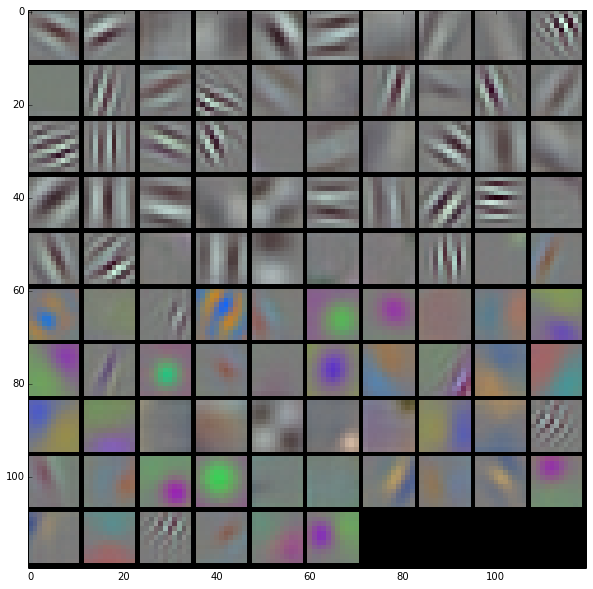

In [28]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))
print "done"

The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

done


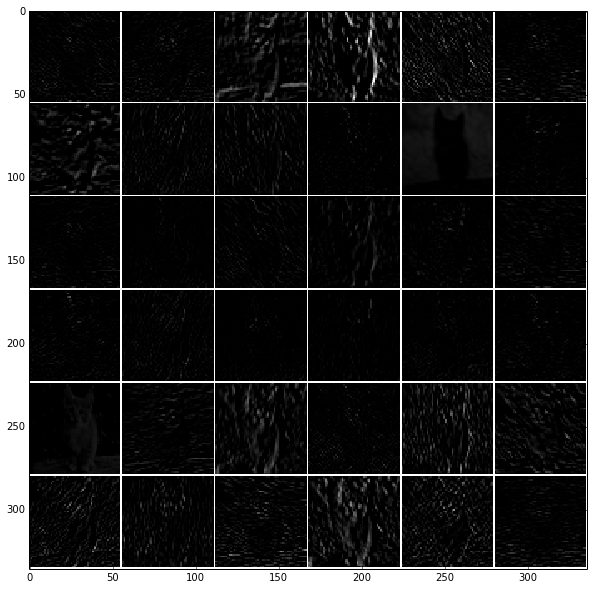

In [29]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat, padval=1)
print "done"

The second layer filters, `conv2`

There are 256 filters, each of which has dimension 5 x 5 x 48. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.

done


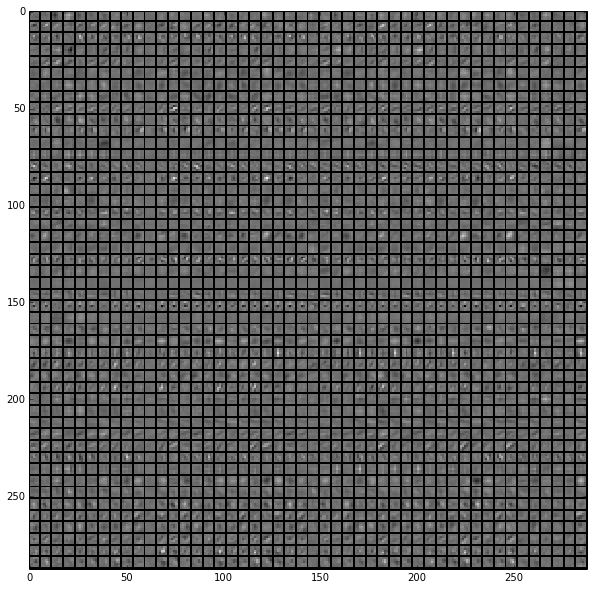

In [30]:
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))
print "done"

The second layer output, `conv2` (rectified, only the first 36 of 256 channels)

done


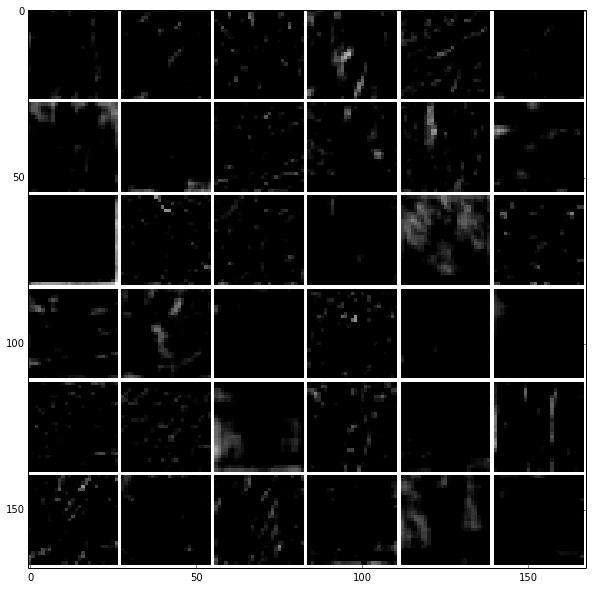

In [31]:
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)
print "done"

The third layer output, `conv3` (rectified, all 384 channels)

done


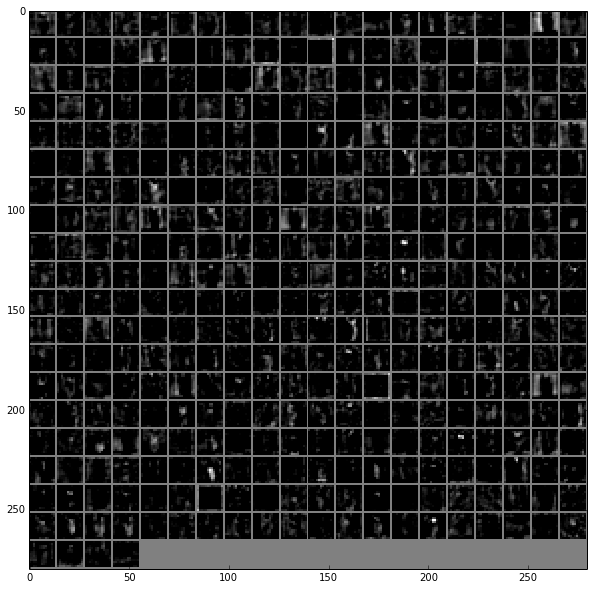

In [32]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)
print "done"

The fourth layer output, `conv4` (rectified, all 384 channels)

done


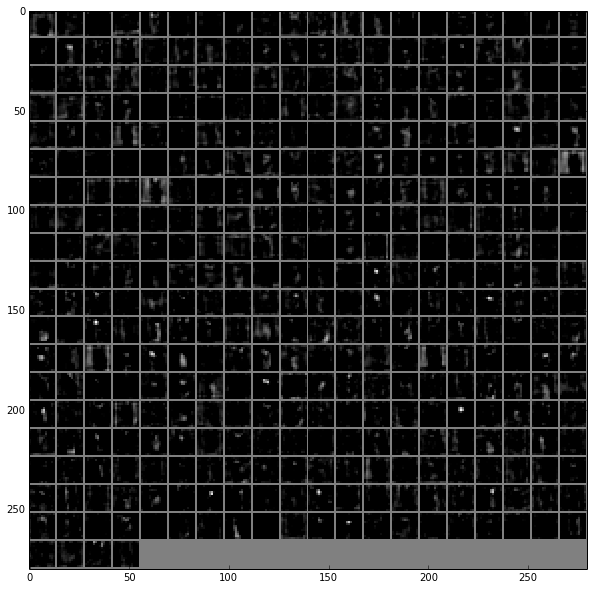

In [33]:
feat = net.blobs['conv4'].data[0]
vis_square(feat, padval=0.5)
print "done"

The fifth layer output, `conv5` (rectified, all 256 channels)

done


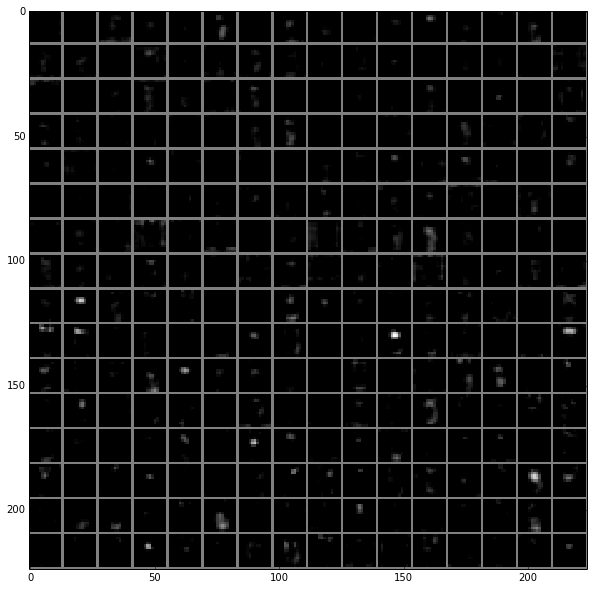

In [34]:
feat = net.blobs['conv5'].data[0]
vis_square(feat, padval=0.5)
print "done"

The fifth layer after pooling, `pool5`

done


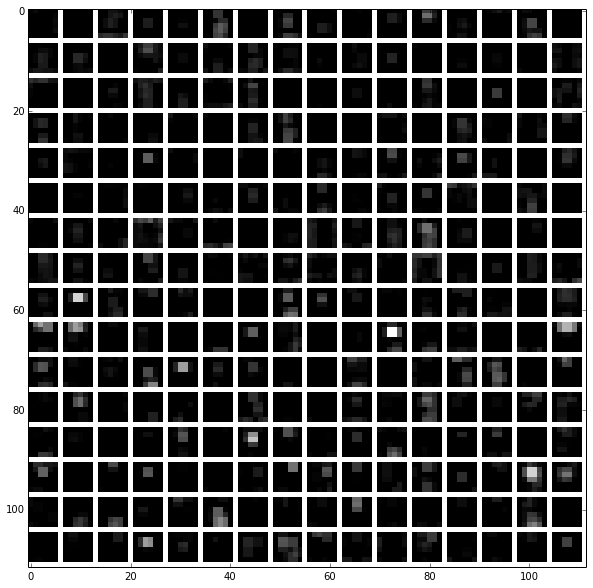

In [35]:
feat = net.blobs['pool5'].data[0]
vis_square(feat, padval=1)
print "done"

The first fully connected layer, `fc6` (rectified)

We show the output values and the histogram of the positive values

done


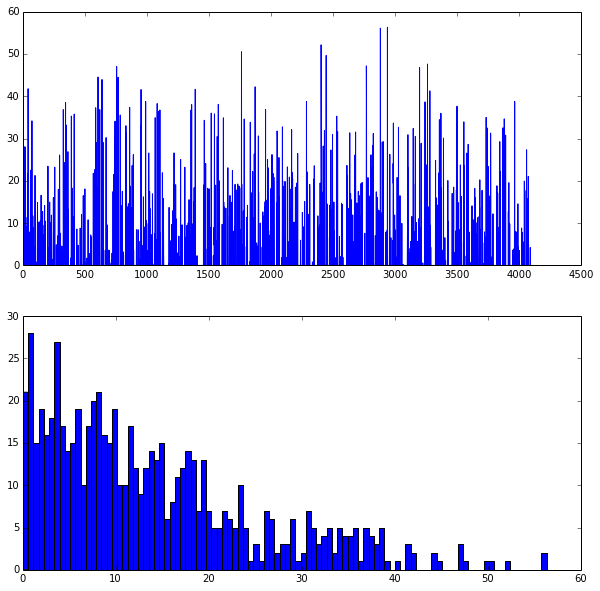

In [36]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)
print "done"

The second fully connected layer, `fc7` (rectified)

done


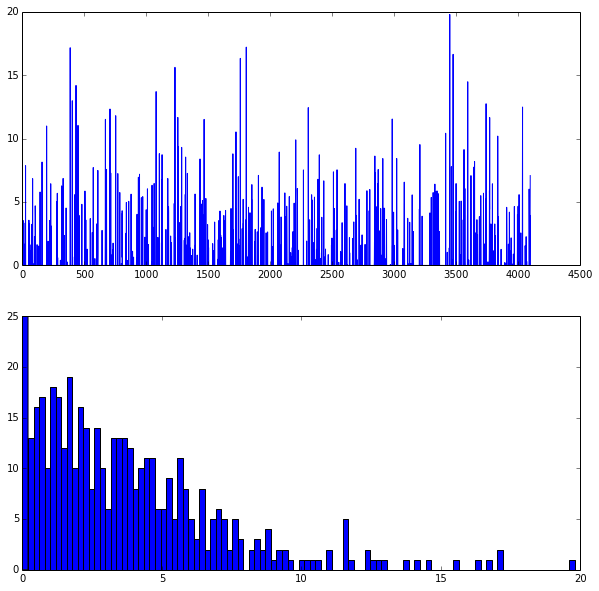

In [37]:
feat = net.blobs['fc7'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)
print "done"

The final probability output, `prob`

done


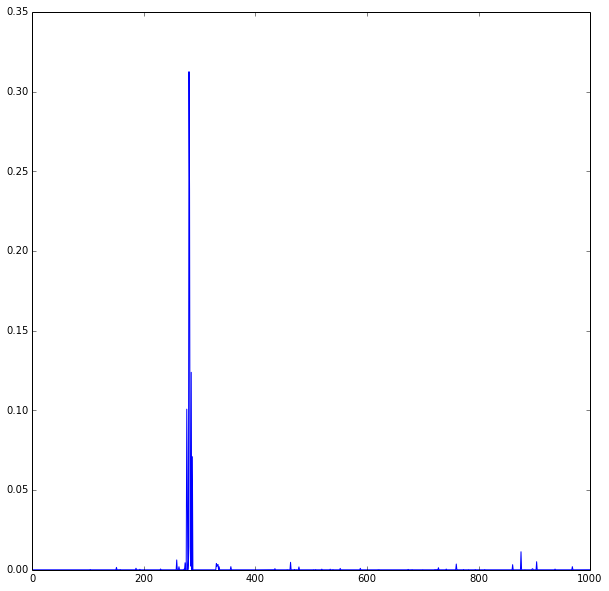

In [38]:
feat = net.blobs['prob'].data[0]
plt.plot(feat.flat)
print "done"

Let's see the top 5 predicted labels.

In [39]:
# load labels
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print labels[top_k]
print "done"

['n02123045 tabby, tabby cat' 'n02123159 tiger cat'
 'n02124075 Egyptian cat' 'n02119022 red fox, Vulpes vulpes'
 'n02127052 lynx, catamount']
done
